### Fraud Analytics Assignment 2 :
### Team Members : 
### 1.CS22BTECH11012 - Bolla NehaSree
### 2.CS22BTECH11043 - Nethi Keerthana
### 3.ES22BTECH11025 - N.Krishna Chaitanya

### Import the Necessary Libraries

In [28]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 1.load_data(filename): Loads a dataset from a CSV file, extracts features (X), binary target labels (y), and false negative costs (fn_costs)
### 2.scale_features(X_train, X_test): Standardizes the feature values using StandardScaler to improve model performance.

In [29]:
#Load Dataset
def load_data(filename):
    data = pd.read_csv(filename)
    X = data.iloc[:, :-2].values  # Features
    y = data.iloc[:, -2].values   # Binary target (0 or 1)
    fn_costs = data.iloc[:, -1].values  # False Negative costs (varies per sample)
    return X, y, fn_costs

#Normalize Features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


### 1.sigmoid(z): Computes the sigmoid activation function, which maps input values to probabilities between 0 and 1.

### 2.cost_sensitive_loss(theta, X, y, fn_costs, tp_cost=3, fp_cost=3, tn_cost=0): Implements a custom loss function that incorporates varying false negative costs (fn_costs) per sample, along with predefined costs for true positives, false positives, and true negatives. 

In [30]:
#Sigmoid Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Cost-Sensitive Loss Function
def cost_sensitive_loss(theta, X, y, fn_costs, tp_cost=3, fp_cost=3, tn_cost=0):
    predictions = sigmoid(np.dot(X, theta))
    
    # Compute individual losses
    tp_loss = y * predictions * tp_cost
    fn_loss = y * (1 - predictions) * fn_costs  
    fp_loss = (1 - y) * predictions * fp_cost
    tn_loss = (1 - y) * (1 - predictions) * tn_cost  

    return np.mean(tp_loss + fn_loss + fp_loss + tn_loss)

### 1.initialize_population(pop_size, num_features): Creates an initial population of random weight vectors for optimization.

### 2.evaluate_fitness(population, X, y, fn_costs, tp_cost, fp_cost, tn_cost): Computes the fitness (loss) for each individual in the population using the cost-sensitive loss function.

### 3.tournament_selection(population, fitness_scores, tournament_size=3): Selects individuals for the next generation by choosing the best out of randomly sampled candidates.

### 4.crossover(parent1, parent2): Performs one-point crossover to create offspring by combining genetic material from two parents.

### 5.mutate(individual, mutation_rate=0.1): Introduces small random changes to an individual's genes to maintain genetic diversity.

In [31]:
#Initialize Population
def initialize_population(pop_size, num_features):
    return np.random.uniform(-1, 1, (pop_size, num_features))

#Evaluate Fitness
def evaluate_fitness(population, X, y, fn_costs, tp_cost, fp_cost, tn_cost):
    return np.array([
        cost_sensitive_loss(ind, X, y, fn_costs, tp_cost, fp_cost, tn_cost) for ind in population
    ])

#Tournament Selection
def tournament_selection(population, fitness_scores, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        indices = np.random.choice(len(population), tournament_size, replace=False)
        best = indices[np.argmin(fitness_scores[indices])]  # Select with lowest loss
        selected.append(population[best])
    return np.array(selected)

#Crossover Function
def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    child1 = np.concatenate((parent1[:point], parent2[point:]))
    child2 = np.concatenate((parent2[:point], parent1[point:]))
    return child1, child2

#Mutation Function
def mutate(individual, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        index = np.random.randint(len(individual))
        individual[index] += np.random.normal(0, 0.1)
    return individual

### This function implements a Genetic Algorithm to optimize a cost-sensitive classifier. It evolves a population of weight vectors through selection, crossover, and mutation over multiple generations, minimizing the cost-sensitive loss. The best weight vector is returned after optimization.

In [32]:
#Genetic Algorithm
def genetic_algorithm(X, y, fn_costs, tp_cost=3, fp_cost=3, tn_cost=0, pop_size=50, generations=100, mutation_rate=0.1):
    num_features = X.shape[1]
    population = initialize_population(pop_size, num_features)

    for gen in range(generations):
        fitness_scores = evaluate_fitness(population, X, y, fn_costs, tp_cost, fp_cost, tn_cost)
        population = tournament_selection(population, fitness_scores)

        new_population = []
        for i in range(0, len(population) - 1, 2):  
            child1, child2 = crossover(population[i], population[i + 1])
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))

        if len(new_population) < pop_size:  
            new_population.append(mutate(population[-1], mutation_rate))

        population = np.array(new_population)

        if gen % 10 == 0:
            print(f"Generation {gen}, Best Loss: {np.min(fitness_scores)}")

    best_index = np.argmin(fitness_scores)
    best_vector = population[best_index]

    print("\n Best Weight Vector Found:")
    print(best_vector)

    return best_vector

### This code trains a cost-sensitive classifier using a Genetic Algorithm, evaluates it across different thresholds, and computes accuracy and cost-sensitive loss for both training and test sets.

In [33]:
#Predict Function
def predict_with_threshold(X, weights, threshold=0.5):
    probs = sigmoid(X @ weights)
    return (probs >= threshold).astype(int)

#Evaluate Model
def evaluate_model(y_true, y_pred, fn_costs):
    accuracy = np.mean(y_pred == y_true)

    # Compute cost-sensitive loss for predictions
    false_negatives = (y_true == 1) & (y_pred == 0)
    false_positives = (y_true == 0) & (y_pred == 1)

    total_cost = np.sum(false_negatives * fn_costs) + np.sum(false_positives * 3)  # FP cost = 3
    return accuracy, total_cost

# Train and Test
def train_and_evaluate(filename,thresholds,test_size=0.2):
    # Load Data
    X, y, fn_costs = load_data(filename)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test, fn_cost_train, fn_cost_test = train_test_split(X, y, fn_costs, test_size=test_size, random_state=42)
    
    # Scale Features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    # Train Genetic Algorithm
    best_weights = genetic_algorithm(X_train_scaled, y_train, fn_cost_train)
    train_costs,test_costs = [],[]

    # Evaluate for Different Thresholds
    print("\n **Threshold Analysis**")
    for threshold in thresholds:
        y_train_pred = predict_with_threshold(X_train_scaled, best_weights, threshold)
        y_test_pred = predict_with_threshold(X_test_scaled, best_weights, threshold)
    
        train_acc, train_cost = evaluate_model(y_train, y_train_pred, fn_cost_train)
        test_acc, test_cost = evaluate_model(y_test, y_test_pred, fn_cost_test)
    
        # Compute Average Costs
        avg_train_cost = train_cost / len(y_train)
        avg_test_cost = test_cost / len(y_test)
        train_costs.append(avg_train_cost)
        test_costs.append(avg_test_cost)
    
        print(f"\nThreshold: {threshold}")
        print(f"🔹 Train Accuracy: {train_acc:.4f}, Train Cost: {train_cost:.2f}, Avg Train Cost: {avg_train_cost:.4f}")
        print(f"🔹 Test Accuracy: {test_acc:.4f}, Test Cost: {test_cost:.2f}, Avg Test Cost: {avg_test_cost:.4f}")
    return train_costs,test_costs


### This function evaluates a standard Logistic Regression model, applying feature scaling, training the model, and analyzing its performance across different thresholds using accuracy and cost-sensitive loss metrics.

In [34]:
from sklearn.linear_model import LogisticRegression
#Train and Evaluate Standard Logistic Regression
def evaluate_standard_lr(X, y, fn_costs, thresholds):
    X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
        X, y, fn_costs, test_size=0.2, random_state=42, stratify=y
    )

    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    std_train_costs, std_test_costs = [], []

    print("\n **Standard Logistic Regression - Threshold Analysis**")
    for threshold in thresholds:
        y_train_pred = (model.predict_proba(X_train_scaled)[:, 1] >= threshold).astype(int)
        y_test_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)

        train_acc, train_cost = evaluate_model(y_train, y_train_pred, fn_train)
        test_acc, test_cost = evaluate_model(y_test, y_test_pred, fn_test)

        avg_train_cost = train_cost / len(y_train)
        avg_test_cost = test_cost / len(y_test)
        std_train_costs.append(avg_train_cost)
        std_test_costs.append(avg_test_cost)

        print(f"\nThreshold: {threshold}")
        print(f"🔹 Train Accuracy: {train_acc:.4f}, Train Cost: {train_cost:.2f}, Avg Train Cost: {avg_train_cost:.4f}")
        print(f"🔹 Test Accuracy: {test_acc:.4f}, Test Cost: {test_cost:.2f}, Avg Test Cost: {avg_test_cost:.4f}")
    return std_train_costs,std_test_costs

### This code trains and evaluates a standard Logistic Regression model using different classification thresholds, computing accuracy and cost-sensitive loss for both training and test sets.

In [35]:
# Run Training and Evaluation
thresholds = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8,0.9]

# Train & Evaluate Standard Logistic Regression
X, y, fn_costs = load_data("data.csv")
std_train_costs,std_test_costs = evaluate_standard_lr(X, y, fn_costs, thresholds)



 **Standard Logistic Regression - Threshold Analysis**

Threshold: 0
🔹 Train Accuracy: 0.2986, Train Cost: 248529.00, Avg Train Cost: 2.1043
🔹 Test Accuracy: 0.2986, Test Cost: 62133.00, Avg Test Cost: 2.1042

Threshold: 0.1
🔹 Train Accuracy: 0.7911, Train Cost: 1110748.39, Avg Train Cost: 9.4045
🔹 Test Accuracy: 0.7938, Test Cost: 245960.82, Avg Test Cost: 8.3297

Threshold: 0.2
🔹 Train Accuracy: 0.8425, Train Cost: 1759650.06, Avg Train Cost: 14.8987
🔹 Test Accuracy: 0.8448, Test Cost: 429776.71, Avg Test Cost: 14.5549

Threshold: 0.3
🔹 Train Accuracy: 0.8582, Train Cost: 2508660.42, Avg Train Cost: 21.2404
🔹 Test Accuracy: 0.8615, Test Cost: 525657.83, Avg Test Cost: 17.8020

Threshold: 0.4
🔹 Train Accuracy: 0.8649, Train Cost: 2938026.98, Avg Train Cost: 24.8758
🔹 Test Accuracy: 0.8654, Test Cost: 633508.66, Avg Test Cost: 21.4545

Threshold: 0.5
🔹 Train Accuracy: 0.8656, Train Cost: 3478314.08, Avg Train Cost: 29.4503
🔹 Test Accuracy: 0.8686, Test Cost: 787702.76, Avg Test Cost: 

### This code trains and evaluates a Genetic Algorithm-based model, analyzing its performance across different classification thresholds by measuring accuracy and cost-sensitive loss for both training and test sets.

In [36]:
# Train & Evaluate Genetic Algorithm Model
sen_train_costs,sen_test_costs = train_and_evaluate("data.csv",thresholds)


Generation 0, Best Loss: 22.69934317979936
Generation 10, Best Loss: 6.388506735664516
Generation 20, Best Loss: 5.324367286310766
Generation 30, Best Loss: 5.09111070838426
Generation 40, Best Loss: 4.58434961142913
Generation 50, Best Loss: 4.2632659223766876
Generation 60, Best Loss: 3.9636926877402154
Generation 70, Best Loss: 3.7192804586248984
Generation 80, Best Loss: 3.578909637568722
Generation 90, Best Loss: 3.4372361109763747

 Best Weight Vector Found:
[ 1.67556141 -2.00992656  1.80518759 -0.15873191  0.9164564   0.65576073
  0.84036185  0.55314764  1.06584419  0.43879172  0.21359063]

 **Threshold Analysis**

Threshold: 0
🔹 Train Accuracy: 0.2985, Train Cost: 248541.00, Avg Train Cost: 2.1044
🔹 Test Accuracy: 0.2987, Test Cost: 62121.00, Avg Test Cost: 2.1038

Threshold: 0.1
🔹 Train Accuracy: 0.6380, Train Cost: 145384.95, Avg Train Cost: 1.2309
🔹 Test Accuracy: 0.6373, Test Cost: 37307.01, Avg Test Cost: 1.2634

Threshold: 0.2
🔹 Train Accuracy: 0.6758, Train Cost: 160533.

### This plots the average training and testing costs for both standard logistic regression and cost sensitive classification against various offset values

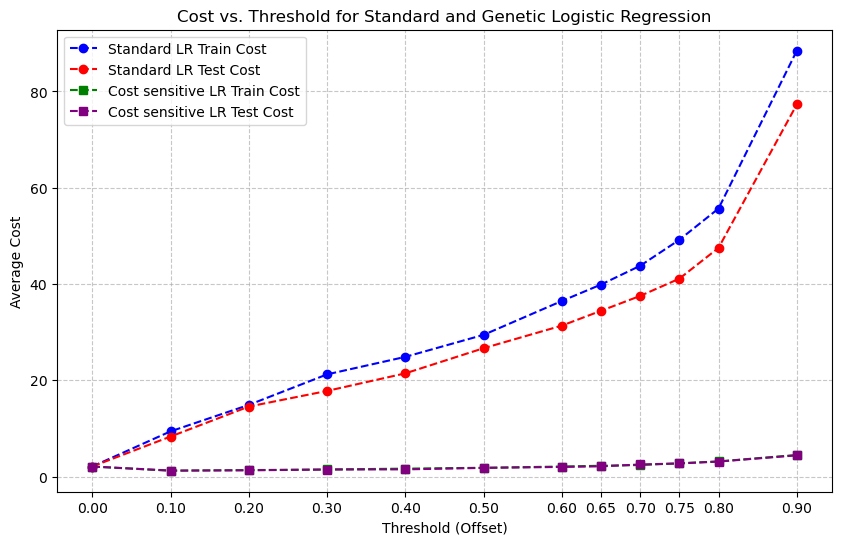

In [37]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))

# Standard Logistic Regression
plt.plot(thresholds, std_train_costs, label="Standard LR Train Cost", linestyle="dashed", marker="o", color='blue')
plt.plot(thresholds, std_test_costs, label="Standard LR Test Cost", linestyle="dashed", marker="o", color='red')

# Genetic Algorithm Logistic Regression
plt.plot(thresholds, sen_train_costs, label="Cost sensitive LR Train Cost", linestyle="dashed", marker="s", color='green')
plt.plot(thresholds, sen_test_costs, label="Cost sensitive LR Test Cost", linestyle="dashed", marker="s", color='purple')

plt.xlabel("Threshold (Offset)")
plt.ylabel("Average Cost")
plt.title("Cost vs. Threshold for Standard and Genetic Logistic Regression")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(thresholds)  # Ensure all threshold values are shown
plt.savefig("plot.png", dpi=300, bbox_inches="tight")
plt.show()

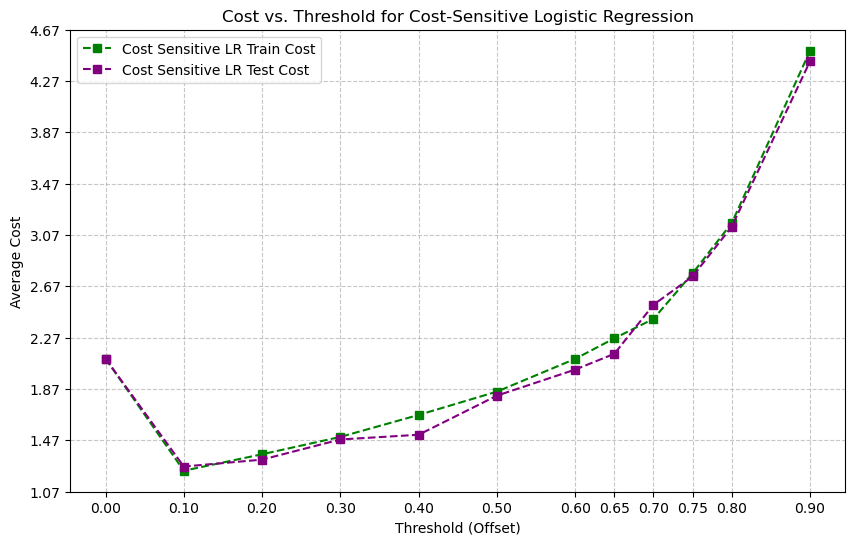

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define y-axis limits with some margin
y_min = min(min(sen_train_costs), min(sen_test_costs))
y_max = max(max(sen_train_costs), max(sen_test_costs))
y_range = y_max - y_min

# Expand limits slightly for better visualization
y_min -= 0.05 * y_range
y_max += 0.05 * y_range

# Define custom y-ticks for better resolution
num_ticks = 10  # Adjust the number of ticks for better spacing
y_ticks = np.linspace(y_min, y_max, num_ticks)

# Plotting
plt.figure(figsize=(10, 6))

# Cost-Sensitive Logistic Regression
plt.plot(thresholds, sen_train_costs, label="Cost Sensitive LR Train Cost", linestyle="dashed", marker="s", color='green')
plt.plot(thresholds, sen_test_costs, label="Cost Sensitive LR Test Cost", linestyle="dashed", marker="s", color='purple')

plt.xlabel("Threshold (Offset)")
plt.ylabel("Average Cost")
plt.title("Cost vs. Threshold for Cost-Sensitive Logistic Regression")

# Set manual y-axis limits and ticks
plt.ylim(y_min, y_max)
plt.yticks(y_ticks, labels=[f"{tick:.2f}" for tick in y_ticks])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(thresholds)  # Ensure all threshold values are shown
plt.savefig("cost_sensitive_plot_scaled.png", dpi=300, bbox_inches="tight")
plt.show()
